# Multi-Template Matching

**This notebook will be in english and spanish but code is mainly in english.**
**Este cuaderno se escribió en inglés y español, sin embargo, el código será principalmente en inglés.**

---------------

**REQUIRED LIBRARIES** // **Librerias necesarias**

- Numpy 
- OpenCV
- argparse
- Matplotlib

-------------
## Argparse

**Why Argparse?** // **¿Por qué Argparse?**

With Argparse we can use this python function to template match from command line/Terminal/PowerShell.

Con Argparse podemos utilizar este código de Python desde la línea de comandos/Terminal/PowerShell.

In [1]:
# Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse
import logging as log

log.basicConfig(level=log.INFO,
                format='[%(filename)s:%(lineno)s] %(message)s',
                datefmt="%I:%M:%S %p")

In [52]:
#%% Obtención de los parametros
# Create a group for the arguments
# Creamos el grupo de argumentos
'''
    -i, --image:        Path to the image. REQUIRED 
                        Ruta de la imagen. REQUERIDO
    -t, --template:     Path to the template. REQUIRED
                        Ruta de la plantilla. REQUERIDO
    -b, --threshold:    Threshold for the template matching. Default 0.6
                        Umbral para la coincidencia de la plantilla. Por defecto 0.6
    -v, --visualize:    Flag to show the results. Default False
                        Bandera para mostrar los resultados. Por defecto False
'''

image_path = r'D:\Programacion\ComputerVision\template-matching\images\images\cartas_logos.webp'
template_path = r'D:\Programacion\ComputerVision\template-matching\images\templates\cartas_Corazon.png'
threshold = 0.6

[<ipython-input-53-72b6ab5920c1>:3] [INFO] Loading the images...
[<ipython-input-53-72b6ab5920c1>:8] [INFO] image shape: (550, 550, 3)
[<ipython-input-53-72b6ab5920c1>:9] [INFO] template shape: (50, 50, 3)


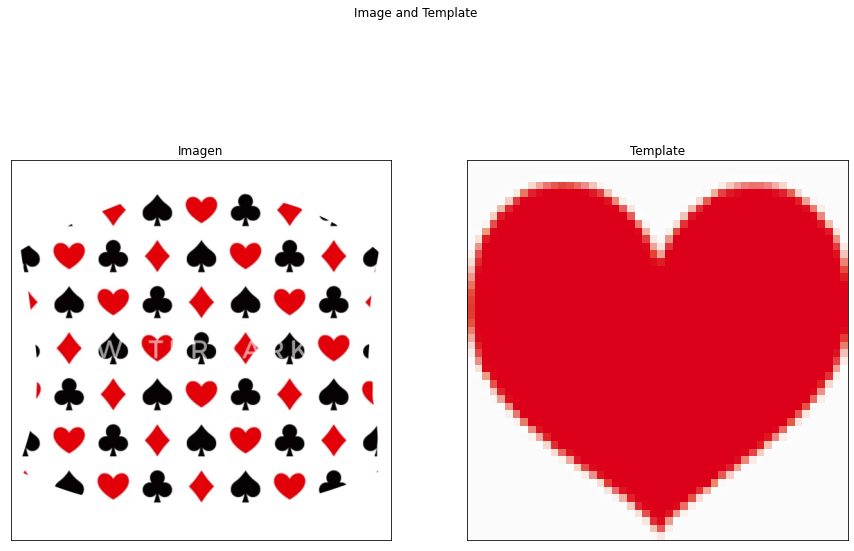

In [53]:
#%% Load the images
# Cargamos las imágenes
log.info("[INFO] Loading the images...")

image = cv2.imread(image_path)
template = cv2.imread(template_path)
template = cv2.resize(template, (50, 50))
log.info(f"[INFO] image shape: {image.shape}")
log.info(f"[INFO] template shape: {template.shape}")
# get template shapes
# obtenemos la dimensión de la plantilla
(tH, tW) = template.shape[:2]

# Show the images
# Mostramos las imágenes
ax, fig = plt.subplots(1, 2, figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(image[:,:,::-1])
plt.title('Imagen')
plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(template[:,:,::-1])
plt.title('Template')
plt.xticks([]), plt.yticks([])
plt.suptitle('Image and Template')
plt.show()

----------------
## Image Normalization

In [54]:
#%% Normalization of the images
# Normalizamos las imagenes
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

----------
## Perfom template Matching

In [55]:
log.info("[INFO] Normalizing the images.")

result = cv2.matchTemplate(image_gray, template_gray, cv2.TM_CCOEFF_NORMED)
result.shape

[<ipython-input-55-064d55a9ba59>:1] [INFO] Normalizing the images.


(501, 501)

If you want to look just one object (the one with the max correlation) you can use
`cv2.minMaxLoc` function to find the _(x, y)_ coordinates with the largest normalized correlation coefficient.

However, we want to detect multiple objects so we need to filter the `result` matrix and find all _(x, y)_ coordinates that have a score greater than `threshold`.

---------

Si quieres encontrar solo un objeto (aquel con la maxima correlación), puedes utilizar la función `cv2.minMaxLoc` para encontrar las coordenadas _(x, y)_ con el mayor coeficiente de correlación normalizado.

Sin embargo, queremos detectar distintos objetos, por lo que requerimos filtrar la matríz `result` para encontrar todas las coordenadas _(x, y)_ con un valor mayor al de `threshold`.


[<ipython-input-63-a40b8bf8c649>:15] [INFO] Detected 1399 matched locations before NMS.


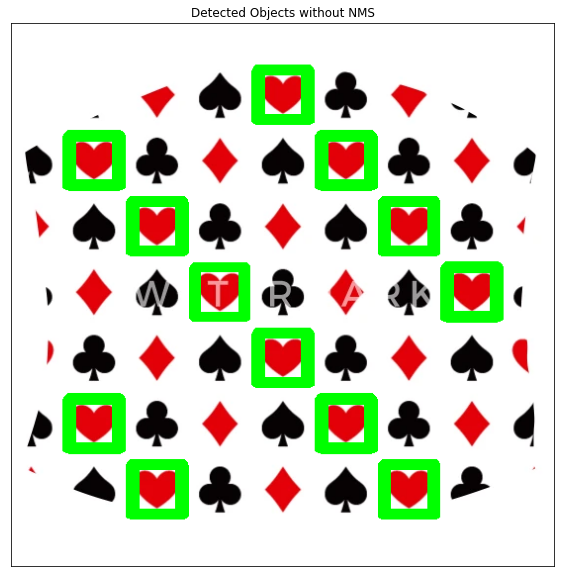

In [63]:
#%% Multiple Object Detection
# Detectamos varios objetos
'''
Find all locations in the result map where the matched value is greater 
than the threshold. We copy the image to draw over it
-----------
Encontramos todas las ubicaciones en el mapa de resultados donde el valor de
coincidencia es mayor que el umbral. Copiamos la imagen para dibujar sobre ella
'''

(y_coord, x_coord) = np.where(result >= threshold) 
clone = image.copy()

# Se detectaron *y_coord* objetos antes de aplicar Non-Maximum Suppression
log.info(f"[INFO] Detected {len(y_coord)} matched locations before NMS.")

# Draw a rectangle around the matched region
for (x, y) in zip(x_coord, y_coord):
    cv2.rectangle(clone, (x, y), (x + tW, y + tH), (0, 255, 0), 1)

# Show image
plt.figure(figsize=(15, 10))
plt.imshow(clone[:,:,::-1])
plt.title('Detected Objects without NMS')
plt.xticks([]), plt.yticks([])
plt.show()

You'll see big rectangles and 1399 matched locations. What happened is that lot of
re-matching were made, that's why we have big squares, they are lots of detections. That's why we're gonna use NMS, it will discard duplicates.

--------

Verás que existen muchos rectangulos y se hicieron 1399 detecciones. Lo que ocurrio fue que hubo muchas detecciones duplicadas y se amontonaron una sobre otra, razón por la cual tenemos rectangulos tan grandes. Por ello es que usaremos NMS, para descartar todos los duplicados.


## Non-Maximum Suppression
**Supresión no maxima**

We're gonna define a function to use the NMS.

------

Crearemos una función para utilizar NMS.


In [64]:
def non_max_supression(boxes: np.ndarray, overlapThresh=0.6) -> np.ndarray:
    # If not boxes were passed return an empty list
    if len(boxes) == 0:
        return []
    
    # Convert boxes to float
    # This is important as we'll do a lot of divisions
    # Se convierte la variable boxes a flotante
    # Esto se hace debido a que vamos a hacer muchas divisiones
    if boxes.dtype.kind == 'i':
        boxes = boxes.astype('float')

    # Initialize the list of picked indexes
    # Inicializamos la lista de índices seleccionados
    pick = []

    # Grab the coordinates of the bounding boxes
    # Obtenemos las coordenadas de las cajas delimitadoras
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Compute the area of the bounding boxes and sort the 
    # bounding boxes by the bottm-right y-coordinate of the bounding box
    # Calculamos el área de las cajas delimitadoras y las ordenamos 
    # por la coordenada inferior derecha y-coordenada de la caja
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # Keep looping while some indexes still remain in the indexes list
    # Mientras que algunos índices aún queden en la lista de índices
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index 
        # value to the list of picked indexes
        # Obtenemos el último índice en la lista de índices y lo agregamos
        # a la lista de índices seleccionados
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding box
        # Encontramos las coordenadas más grandes (x, y) para el inicio de la caja
        # delimitadora y las coordenadas más pequeñas (x, y) para el final de la caja
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.maximum(y2[i], y2[idxs[:last]])

        # Compute the width and height of the bounding box
        # Calculamos el ancho y el alto de la caja delimitadora
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the ratio of overlap
        # Calculamos la proporción de superposición
        overlap = (w * h) / area[idxs[:last]]

        # Delete all indexes from the index list that have
        # overlap greater than the provided overlap threshold
        # Eliminamos todos los índices de la lista de índices que tienen
        # una superposición mayor que el umbral de superposición proporcionado
        idxs = np.delete(idxs, 
                        np.concatenate(([last], 
                                        np.where(overlap > overlapThresh)[0])
                                        )
                        )
    # Return only the bounding boxes that were picked using the integer data type
    return boxes[pick].astype('int')


-------------
## Using the NMS algorithm to clean the output

 **Uso del algoritmo NMS para limpiar la detecciones**

[<ipython-input-68-75418425fbf7>:15] [INFO] Detected 7 matched locations AFTER NMS.


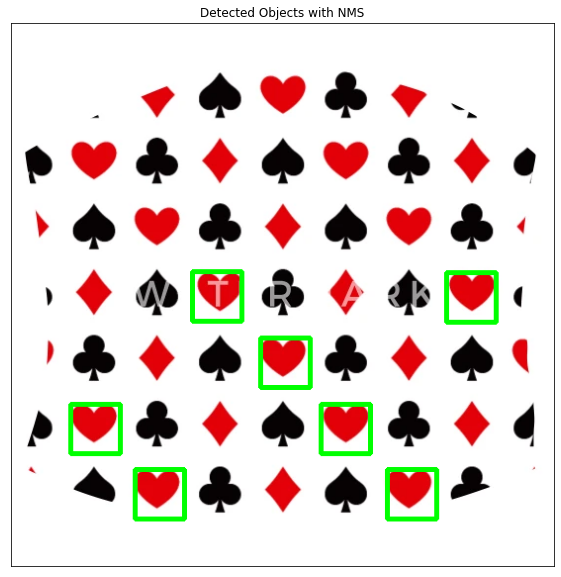

In [68]:
#%% Using the NMS algorithm

# Initializing our list of rectangles and a new clone
rects = []
del clone; clone = image.copy()

# Loop over the starting (x, y)-coordinates of the bounding boxes
for (x, y) in zip(x_coord, y_coord):
    # Update our list of rectangles
    rects.append((x, y, x + tW, y + tH))

# Apply the NMS algorithm
# Aplicando el algoritmo NMS
pick = non_max_supression(np.array(rects), 0.6)
log.info(f"[INFO] Detected {len(pick)} matched locations AFTER NMS.")

# Loop over the final bounding boxes
# Iteramos sobre las cajas delimitadoras finales
for (xA, yA, xB, yB) in pick:
    # Draw a bounding box around the detected object
    # Dibujamos una caja delimitadora alrededor del objeto detectado
    cv2.rectangle(clone, (xA, yA), (xB, yB), (0, 255, 0), 3)

# Show the image after NMS
# Mostramos la imagen después de NMS
plt.figure(figsize=(15, 10))
plt.imshow(clone[:,:,::-1])
plt.title('Detected Objects with NMS')
plt.xticks([]), plt.yticks([])
plt.show()

-----------

## Problems

**Problems**

This method is translation invariant but not rotation and scale invariant, also is highly affected by occlusion, illumination, background changes, etc.

A moder approaching as YOLO, M-RCNN could be a better method but you should train o get a pre-trained model.

---------------

Este metodo es invariante a la traslación, con la contra de que no es invariante a la escala y rotación, además, puede verse afectado por problemas y cambios como oclusión, iluminación, cambios de fondo, etc.

Un método más moderno es el uso de YOLO, M-RCNN, etc, sin embargo se hace necesario entrenar el modelo o encontrar uno pre-entrenado.

